## Imports and Params

In [1]:
# # workaround via specifying an invalid value first
# %config Application.log_level='WORKAROUND'
# # => fails, necessary on Fedora 27, ipython3 6.2.1
# %config Application.log_level='CRITICAL'
import logging

logging.getLogger("pyvips").setLevel(logging.CRITICAL)
logging.getLogger("Debugger").setLevel(logging.CRITICAL)
logging.disable(logging.CRITICAL)
# log = logging.getLogger('pyvips')
# log.debug('Test debug')
logging.StreamHandler().setLevel(logging.DEBUG)


In [2]:
# types
from torch import Tensor
from typing import Union
import __future__

import os
import sys
from glob import glob

# compat
sys.path.append("../src/")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sksurv.linear_model import CoxPHSurvivalAnalysis
from torch.utils.data import DataLoader, Dataset, random_split

from cucim import CuImage

# command `tensorboard --logdir=path/to/logs` to start TensorBoard server, then open http://localhost:6006 to access dashboard.
from torch.utils.tensorboard import SummaryWriter

from src.datasets.downsample_dataset import DownsampleMaskDataset
from src.misc.pyvips_wrapper import numpy2pyramid
from src.misc.geojson_processing import geojson_to_mask


2023-03-15 11:41:07.291589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 11:41:07.421060: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_workers: int = (os.cpu_count() or 0) // torch.cuda.device_count()


# hyperparameters
learning_rate = 0  # Define the learning rate
num_epochs: int = 1  # Define the number of training steps
batch_size: int = 1  # number of samples in a batch
patch_size: int = 400  # size of tiles extracted from WSI


In [4]:
input_dir: str = "/data2/projects/DigiStrudMed_sklein/sample-case/Scans-fuer-QupathProjekt-RCC-3Faelle-10062021/"
output_dir: str = ""

annos_of_interest: list[str] = [
    "Tissue",
    "Tumor_vital",
    "diffuse_tumor_growth_in_soft_tissue",
    "Angioinvasion",
    "Tumor_necrosis",
    "Tumor_regression",
]


## Generate masks from geojson

We first generate masks as numpy arrays from the geojson file, then we save it as a pyramidal tiff.

In [5]:
geojsons: list[str] = sorted(glob(os.path.join(input_dir, "*.json")))
images: list[str] = sorted(glob(os.path.join(input_dir, "*.svs")))
masks = sorted(glob(os.path.join(input_dir, "*.tif")))

rerun = False

for geojson, image in zip(geojsons, images):
    height: int
    width: int
    channels: int
    height, width, channels = CuImage(image).shape

    for anno in annos_of_interest:
        target_file = image.removesuffix(".svs") + f"-{anno}.tif"
        if target_file not in glob(os.path.join(input_dir, "*.tif")) or rerun:
            # print(f"Creating {target_file}")
            masks_np: dict = geojson_to_mask(geojson, [anno], (height, width))
            for anno, arr in masks_np.items():
                assert arr.shape == (height, width)
                # print(f"{anno}--{arr.shape}")
                numpy2pyramid(input_np=arr, path=target_file, tiff_tilesize=512)


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFRe

## Create Dataset

In [6]:
# # images: list[str] = sorted(glob(os.path.join(input_dir, "*.svs")))
# # geojsons: list[str] = sorted(glob(os.path.join(input_dir, "*.json")))

# masks: dict = {}
# for annnotation in annos_of_interest:
#     masks[annnotation.removesuffix(".tif")] = sorted(
#         glob(os.path.join(input_dir, f"*{annnotation}*.tif"))
#     )

# input_dicts: list[dict[str, str]] = [dict(zip(masks, t)) for t in zip(*masks.values())]


In [7]:
input_dir   = "/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/"
geojsons: list[str] = sorted(glob(os.path.join(input_dir, "*.json")))
images: list[str] = sorted(glob(os.path.join(input_dir, "*.svs")))
masks = sorted(glob(os.path.join(input_dir, "*.tif")))

# tabular: pd.DataFrame = pd.read_csv(
#     "/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/survival_status.csv"
# )

In [8]:
from src.datasets.base_dataset import dataset_globber
input_dicts = dataset_globber(input_dir, "/data2/projects/DigiStrudMed_sklein/survival_status.csv")

In [9]:
# # convert from dict of lists to list of dicts
# tmp = []
# for key, values in masks.items():
#     for idx, value in enumerate(values):
#         try:
#             tmp[idx] |= {key: value}
#         except:
#             tmp.append({key: value})
# input_dicts = tmp


In [10]:
training_trans = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomCrop(patch_size),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.01),
    ]  # type: ignore
)
val_trans = transforms.Compose([])


In [11]:
import torchvision
path = "/data2/projects/DigiStrudMed_sklein/DownsampleMaskDataset_Level_1.json"

# if os.path.exists(path):
#     os.remove(path)
#     pass


# input_dicts = list(filter(lambda x: "image" in x.keys(), input_dicts))
from src.datasets.grouped_patch_dataset import GroupedPatchMaskDataset


input_dataset = GroupedPatchMaskDataset(  # PatchMaskDataset(
    input_dicts[:5],
    foreground_key="Tissue",
    image_key="image",
    label_key="surv_days",
    keys=annos_of_interest,
    censor_key="uncensored",
    json_key="geojson",
    cache=False,
    cache_file=path,
    transform=False,
    # target_level=3,
    # normalization_factors=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
)
if len(input_dataset) >= 3:
    train_ds, val_ds, test_ds = random_split(
        input_dataset, [0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42)
    )
    train_ds: torch.utils.data.Dataset
    val_ds: torch.utils.data.Dataset
    test_ds: torch.utils.data.Dataset


Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.001~C.svs
Added 1 patches! Time elapsed: 0.847996711730957
Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.016~B.svs
Added 1 patches! Time elapsed: 0.930537223815918
Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.019~E.svs
Added 1 patches! Time elapsed: 1.2238004207611084
Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.041~B.svs
Added 1 patches! Time elapsed: 1.195558786392212
Adding patches from /data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.042~B.svs
Added 1 patches! Time elapsed: 1.212066650390625


In [16]:
input_dataset.get_sample(3)

{'image': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.041~B.svs',
 'geojson': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.041~B.json',
 'Tumor_regression': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.041~B-Tumor_regression.tif',
 'Tumor_vital': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.041~B-Tumor_vital.tif',
 'Tissue': '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.041~B-Tissue.tif',
 'uncensored': 1.0,
 'surv_days': 218.0,
 'patch_size': 512,
 'num_patches': 26634,
 'case_id': 1,
 'stain_id': 41,
 'locations': [(2693, 60877),
  (2693, 61389),
  (2693, 61901),
  (2693, 62925),
  (2693, 63437),
  (2693, 63949),
  (2693, 64461),
  (2693, 64973),
  (2693, 95693),
  (2693, 96205),
  (2693, 96717),
  (2693, 97229),
  (2693, 97741),
  (2693, 98253),
  (2693, 98765),
  (2693, 99277),
  (2693, 99789),
  (3205, 52173),
  (3205,

In [27]:
input_dataset.get_sample(0)

NameError: name 'input_dataset' is not defined

In [ ]:
counts = input_dataset[0]['data'].unique(return_counts=True)

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


In [14]:
counts[1][2] / 3 == counts[1][1] 

tensor(False)

In [15]:
len(input_dataset)

5

#### Look at single patch

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


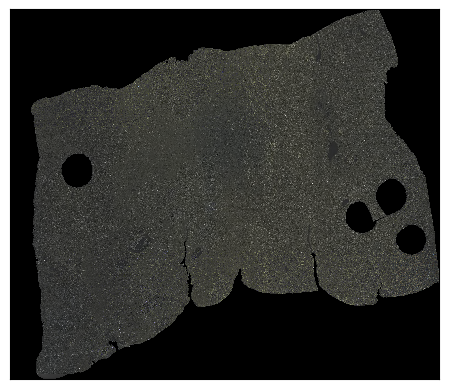

In [16]:

from helpers import show, visualize
from torchvision.utils import make_grid


show(input_dataset[1]['data'][0:3])

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


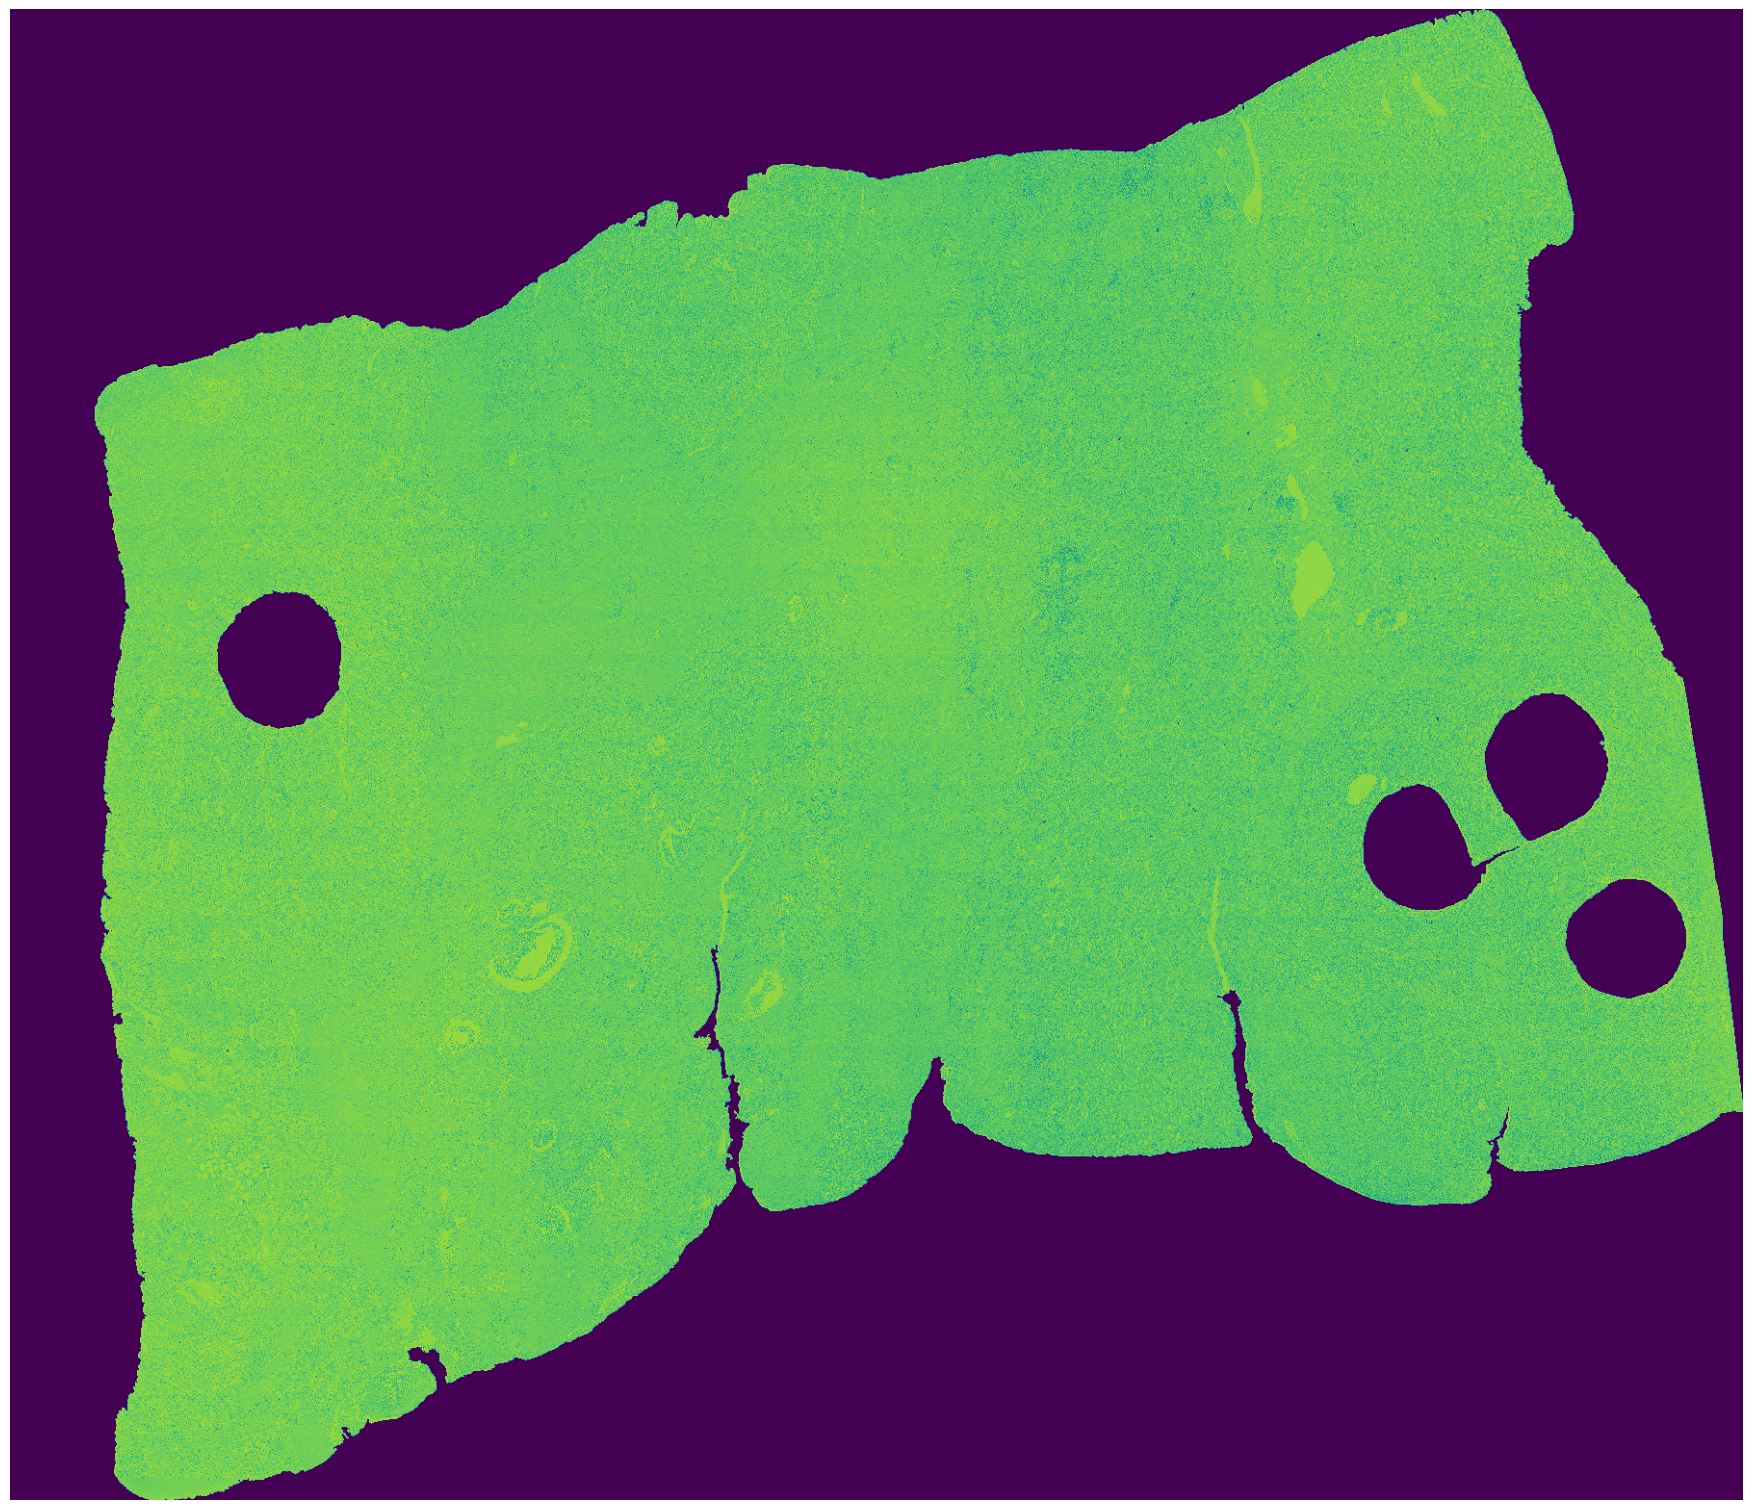

In [17]:
visualize(np.einsum("chw -> hwc",input_dataset[1]['data'][:1]))

In [18]:
(input_dataset[1]['data'][0] == input_dataset[1]['data'][1]).unique(return_counts=True)

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


(tensor([False,  True]), tensor([ 971432, 1816768]))

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


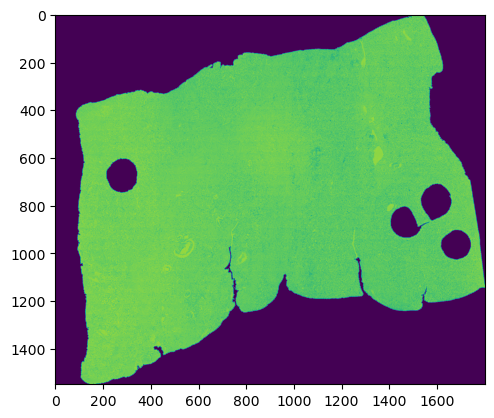

: 

In [23]:
import matplotlib.pyplot as plt
plt.imshow(np.einsum("chw -> hwc",input_dataset[1]['data'][:1]))


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


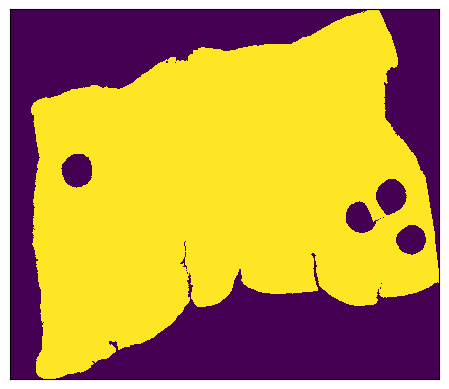

In [20]:
show(input_dataset[1]['data'][3])

TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF directory; tags are not sorted in ascending order.


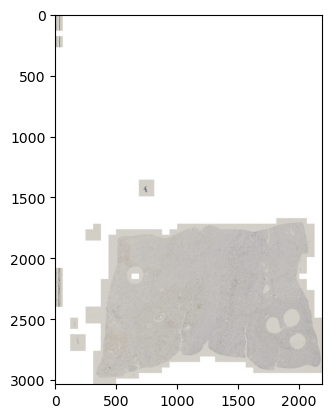

In [18]:
path =  '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.016~B.svs'
# view path with cucim
import cucim
import numpy as np
import matplotlib.pyplot as plt

# read image
img = cucim.CuImage(path)

# get image level 0
level_3 = img.read_region(level=3)

# to numpy
level_3_arr = np.asarray(level_3)

# show image
plt.imshow(level_3_arr)


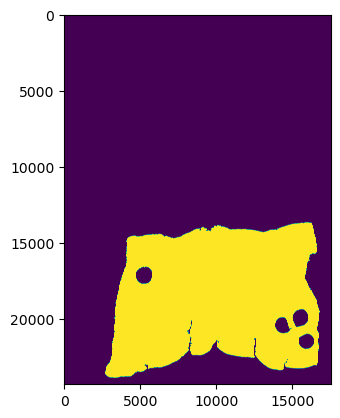

In [19]:
path =  '/data2/projects/DigiStrudMed_sklein/DigiStrucMed_Braesen/all_data/RCC-TA-001.016~B-Tissue.tif'
# view path with cucim
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# read image
img = tifffile.imread(path, series=0, level=3)

# get image level 0
# to numpy
level_3_arr = np.asarray(img)

# show image
plt.imshow(level_3_arr)

## Define Neural Network

In [13]:
net = logging.getLogger("net")
net.setLevel(logging.INFO)
net.disabled = True


class CoxCNN(nn.Module):
    """Implementation based on doi:1504.07947
    "Patch-based Convolutional Neural Network for Whole Slide Tissue Image Classification"
    """

    def __init__(self):
        super(CoxCNN, self).__init__()

        self.conv1: Conv2d = nn.Conv2d(9, 80, kernel_size=(10, 10), stride=2, padding=0)
        self.relu1: ReLU = nn.ReLU()  # same shape as input
        self.lrn1: LocalResponseNorm = nn.LocalResponseNorm(80)  # same shape as input

        # (in + 2 * padding[0] - dialtion[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1
        self.maxpool1: MaxPool2d = nn.MaxPool2d(kernel_size=(6, 6), stride=4, padding=0)
        self.sequence1: Sequential = nn.Sequential(
            self.conv1,
            self.relu1,
            self.lrn1,
            self.maxpool1,
        )

        self.conv2: Conv2d = nn.Conv2d(80, 120, kernel_size=(5, 5), stride=1, padding=0)
        self.relu2: ReLU = nn.ReLU()
        self.lrn2: LocalResponseNorm = nn.LocalResponseNorm(120)
        self.maxpool2: MaxPool2d = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)
        self.sequence2: Sequential = nn.Sequential(
            self.conv2,
            self.relu2,
            self.lrn2,
            self.maxpool2,
        )

        self.conv3: Conv2d = nn.Conv2d(
            120, 160, kernel_size=(3, 3), stride=1, padding=0
        )
        self.relu3: ReLU = nn.ReLU()

        self.conv4: Conv2d = nn.Conv2d(
            160, 200, kernel_size=(3, 3), stride=1, padding=0
        )
        self.relu4: ReLU = nn.ReLU()
        self.maxpool3: MaxPool2d = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=0)
        self.sequence4 = nn.Sequential(
            self.conv4,
            self.relu4,
            self.maxpool3,
        )
        self.sequence3: Sequential = nn.Sequential(
            self.conv3,
            self.relu3,
        )

        self.fc1: Linear = nn.Linear(12800, 320)
        self.relu4: ReLU = nn.ReLU()
        self.dropout1: Dropout = nn.Dropout(p=0.5)
        self.fc2: Linear = nn.Linear(320, 320)
        self.relu5: ReLU = nn.ReLU()
        self.dropout2: Dropout = nn.Dropout(p=0.5)
        self.sequence5: Sequential = nn.Sequential(
            self.fc1,
            self.relu4,
            self.dropout1,
            self.fc2,
            self.relu5,
            self.dropout2,
        )
        self.fc3: Linear = nn.Linear(320, 1)
        # self.softmax: Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        net.info(f"start {x.shape}")
        x = self.sequence1(x)
        net.info(f"cnn1 {x.shape}")
        x = self.sequence2(x)
        net.info(f"cnn2 {x.shape}")
        x = self.sequence3(x)
        net.info(f"cnn3 {x.shape}")
        x = self.sequence4(x)
        net.info(f"cnn4 {x.shape}")

        # x = x.flatten(2)
        net.info(f"flattened {x.shape}")

        x = x.view(x.size(0), -1)
        net.info(f"view {x.shape}")

        x = self.sequence5(x)
        net.info(f"fc1 {x.shape}")

        x = self.fc3(x)
        net.info(f"fc2 {x.shape}")

        return x

        """
        start torch.Size([1, 9, 400, 400])
        cnn1 torch.Size([1, 80, 48, 48])
        cnn2 torch.Size([1, 120, 21, 21])
        cnn3 torch.Size([1, 160, 19, 19])
        cnn4 torch.Size([1, 200, 8, 8])
        view torch.Size([1, 12800])
        
        """


In [14]:
import torchvision.models as models
from torch import optim
from src.misc.metrics import coxnnetLoss
import pytorch_lightning as pl
import torchvision.models as models
from torch.optim import lr_scheduler

pl.seed_everything(42)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


class CoxNet(pl.LightningModule):
    # TODO:
    # For MIL: https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html#id2
    # maybe use self.current_epoch != ? somehow.
    # Run backwards and step in training_step_end and just run the predicition in step
    # use on_train_batch_end or on_train_batch_end or on_train_batch_start, ... # https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#on-train-epoch-end
    # accumulate grads? https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#accumulate-gradients
    # create one dataset per image? https://pytorch-lightning.readthedocs.io/en/stable/guides/data.html#multiple-datasets

    # TODO: move layers and forward to separate nn.module # https://pytorch-lightning.readthedocs.io/en/stable/starter/style_guide.html?highlight=split#datamodules
    def __init__(
        self,
        input_channels,
        class_dims: int = 32,
        num_classes: int = 1,
        lr: float = 1e-2,
    ):
        super(CoxNet, self).__init__()

        self.logger: pl.loggers.Logger
        
        # This gives us access to the dataloader if needed
        # test_dl = self.trainer.test_dataloaders[dataloader_idx]

        self.lr: float = lr
        self.save_hyperparameters()
        # self.log("hp_metric", self.lr)  # check if this works
        self.loss = coxnnetLoss

        # Add 1x1 convolutional layer in front of the network
        self.downsample = nn.Conv2d(input_channels, 3, kernel_size=1)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # https://github.com/mahmoodlab/PathomicFusion/blob/44b5513cb90c31337276bba92abe515e21c7f6ca/networks.py#L328
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(0.25),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(0.25),
            nn.Linear(1024, class_dims),
            nn.ReLU(True),
            nn.Dropout(0.05),
        )

        # self.resnet: models.ResNet = models.resnet18(pretrained=True)
        # # Modify ResNet's last layer
        # self.resnet.fc = nn.Identity()

        # pytorch lighnting expects backbone to be the frozen model
        self.backbone = models.resnet18(weights='DEFAULT')
        num_feats = (
            self.backbone.fc.in_features
        )  # FIXME: can we use this as input  param instead of avgpool?
        self.backbone.fc = nn.Identity()

        layers = list(self.backbone.children())[:-1]  # Remove last layer
        self.feature_extractor = nn.Sequential(*layers)
        self.cnn = nn.Sequential(
            self.downsample, self.feature_extractor  # self.resnet
        )  # or vgg instead of resnet

        # self.vgg = models.vgg16(pretrained=True)
        # # Modify VGG's last layer
        # self.vgg.classifier = nn.Identity()

        # last layer
        self.linear = nn.Linear(class_dims, num_classes)

    def forward(self, x):
        # TODO: dont use forward here, use in specific nn.Modules and move all leftover (connecting them) to training_step
        x = self.downsample(x)
        with torch.no_grad():
            x = self.backbone(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        features = self.classifier(x)
        hazard = self.linear(features)
        return features, hazard

    def training_step(self, batch, batch_idx):
        (inputs, survtime, censor, location, case_id, stain_id) = batch.values()
        prediction = self(inputs)

        loss: torch.Tensor = self.loss(survtime, censor, prediction, self.device)

        # TODO
        c_idx = ""
        pbar = {"train_c_index": c_idx}
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return {"loss": loss, "progress_bar": pbar}

    # def training_step_end(self, batch_parts):
    #     # predictions from each GPU
    #     predictions = batch_parts["pred"]
    #     # losses from each GPU
    #     losses = batch_parts["loss"]
    #     return losses.sum() / len(losses)

    def on_train_epoch_end(self):
        #  the function is called after every epoch is completed
        if(self.current_epoch==1):
            
            sampleImg=torch.rand((1,1,28,28))
            self.logger.log_graph(self,sampleImg)

    def training_epoch_end(self, val_step_outputs):
        # gets all results from validation_step
        avg_train_loss = torch.tensor([x["loss"] for x in val_step_outputs]).mean()
        avg_train_c_index = torch.tensor(
            [x["progress_bar"]["val_c_index"] for x in val_step_outputs]
        ).mean()

        self.log_dict(
            {"avg_train_c_index": avg_train_c_index, "avg_train_loss": avg_train_loss},
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        pbar = {"avg_train_c_index": avg_train_c_index}
        return {"val_loss": avg_train_loss, "progress_bar": pbar}

    def validation_step(self, batch, batch_idx):
        # usually we do not want to log/plot metrics for each val_step
        # instead we want to plot one validation set as a whole
        results = self.training_step(batch, batch_idx)
        results["progress_bar"]["val_c_index"] = results["progress_bar"][
            "train_c_index"
        ]
        del results["progress_bar"]["train_c_index"]
        self.log(
            "val_loss",
            results["loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return results

    def validation_epoch_end(self, val_step_outputs):
        # gets all results from validation_step
        avg_val_loss = torch.tensor([x["loss"] for x in val_step_outputs]).mean()
        avg_val_c_index = torch.tensor(
            [x["progress_bar"]["val_c_index"] for x in val_step_outputs]
        ).mean()

        self.log_dict(
            {"avg_val_c_index": avg_val_c_index, "avg_val_loss": avg_val_loss},
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        pbar = {"avg_val_c_index": avg_val_c_index}
        return {"val_loss": avg_val_loss, "progress_bar": pbar}

    def test_step(self, batch, batch_idx):
        # usually we do not want to log/plot metrics for each val_step
        # instead we want to plot one validation set as a whole
        results = self.training_step(batch, batch_idx)
        results["progress_bar"]["val_c_index"] = results["progress_bar"]["val_c_index"]
        del results["progress_bar"]["val_c_index"]
        self.log(
            "test_loss",
            results["loss"],
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return results

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.lr)
        # FIXME: dont schedule for now, Apparently Adam does adjust it istelf
        scheduler = {
            "scheduler": lr_scheduler.LinearLR(optimizer, 1e-2, 1e-3, 100),
            "interval": "step",  # called after each training step
        }
        # return [optimizer], [scheduler]
        return optimizer


class patchWSIDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, load_workers, ds_class):
        super().__init__()
        self.save_hyperparameters()
        self.batch_size = batch_size
        self.load_workers = load_workers
        self.ds_class = ds_class

        # TODO
        self.transform = None  # transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

    def train_dataloader(self):
        train_dataloader = DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.load_workers,
        )  # True

        # test_dataloader = DataLoader(
        #     self.test_ds, batch_size=batch_size, shuffle=False, num_workers=load_workers,
        # )
        return train_dataloader

    def val_dataloader(self):
        val_dataloader = DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.load_workers,
        )
        return val_dataloader

    def test_dataloader(self):
        test_dataloader = DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.load_workers,
        )
        return test_dataloader

    # TODO: lookup docs if prepare_data and setup are needed,
    # maybe only setup since we do not need to download
    # BELOW: relevant for distributed training
    # def prepare_data(self):
    #     # Stuff happens on a single gpu
    #     # we cannot use self. here
    #     # nodes need access to underlying filesystem
    #     pass

    def setup(self):
        # runs on every single cpu, we can use self here
        # setup copies model to each gpu
        # this will create them reduantly but since we only hold a few file paths that should not be a problem
        input_dataset = self.ds_class(
            input_dicts,
            patch_size=patch_size,
            foreground_key="Tissue",
            image_key="image",
            json_key="geojson",
            label_key="surv_time",
            keys=annos_of_interest,
            censor_key="Uncensored",
            transform=True,
            # normalization_factors=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        )
        self.train_ds: torch.utils.data.Dataset
        self.val_ds: torch.utils.data.Dataset
        self.test_ds: torch.utils.data.Dataset
        self.train_ds, self.val_ds, self.test_ds = random_split(
            input_dataset, [0.7, 0.2, 0.1], generator=torch.Generator().manual_seed(42)
        )


from pytorch_lightning.callbacks import StochasticWeightAveraging, DeviceStatsMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# Alternative profiler (more advanced output)
from pytorch_lightning.profilers import PyTorchProfiler

profiler = PyTorchProfiler(filename="PyTorchProfiler-perf-logs")

model = CoxNet(9)
data = patchWSIDataModule(
    batch_size=batch_size, load_workers=load_workers, ds_class=DownsampleMaskDataset
)
trainer = pl.Trainer(
    fast_dev_run=1,  # defines number of batches for test/train/val # TODO: remove this later
    overfit_batches=10,  # use this to overfit on purpose (10 batches)
    default_root_dir="/data2/projects/DigiStrudMed_sklein/",
    # time of lightning module func calls
    profiler="simple",
    logger=TensorBoardLogger(
        save_dir="/data2/projects/DigiStrudMed_sklein/",
        name=data.ds_class.__name__,
        max_queue=10,  # only keep 10 metrics in memory
        flush_secs=120,  # flush every 2 minutes
    ),
    precision=32,  # changing this to 16 might make the training faster
    max_epochs=5,
    accelerator='gpu',
    devices=4,  #torch.cuda.device_count(),
    num_nodes=1,
    # strategy="ddp_spawn",  # 'dp' = multiple-gpus, 1 machine, ddp is to be preferred apparently
    callbacks=[
        # check if gpu is used fully, monitor itself runs on cpu (?)
        DeviceStatsMonitor(cpu_stats=True),
        # TODO: https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/
        StochasticWeightAveraging(swa_lrs=1e-2),
        # https://pytorch-lightning.readthedocs.io/en/stable/common/early_stopping.html
        EarlyStopping(
            monitor="val_loss",
            mode="min",  # stop if the metric does not decrease # FIXME: check if loss func is maximized or minimized
            patience=3,  # at least 3 Epochs if check_val_every_n_epoch in trainer equals 1 (formula: check_val_every_n_epoch * (patence + 1))
        ),
    ],
    # auto_scale_batch_size="binsearch",  # or "power" # https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#batch-size-finder
    auto_lr_find=True,  # https://pytorch-lightning.readthedocs.io/en/stable/advanced/training_tricks.html#learning-rate-finder # TODO: https://arxiv.org/abs/1506.01186
    num_sanity_val_steps=2,  # runs 2 batches of validation data before training, lower this?
)


# FIXME: apparently batch size does not work with DDP
# Find the batch size `auto_scale_batch_size` and the learning rate `auto_lr_find` automatically
# TODO check if values actually change
# FXIME: maybe use BatchSizeFinder instead and run after each batch and concat batches beforehand? https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.BatchSizeFinder.html#pytorch_lightning.callbacks.BatchSizeFinder
trainer.tune(model, datamodule=data)

trainer.fit(model, data)

# (1) load the best checkpoint automatically (lightning tracks this for you)
trainer.test(ckpt_path="best")

# (2) load the last available checkpoint
trainer.test(ckpt_path="last")

# (3) test using a specific checkpoint
trainer.test(ckpt_path="/path/to/my_checkpoint.ckpt")

# (4) test with an explicit model (will use this model and not load a checkpoint)
trainer.test(model)

# model = MyLightningModule.load_from_checkpoint("/path/to/checkpoint.ckpt")

# # disable randomness, dropout, etc...
# model.eval()

# # predict with the model
# y_hat = model(x)


# TODO: maybe use this https://torchmetrics.readthedocs.io/en/stable/regression/concordance_corr_coef.html?highlight=concordance
# TODO: use this for CI index implementation? https://pytorch-lightning.readthedocs.io/en/stable/visualize/logging_advanced.html#enable-metrics-for-distributed-training


/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/sklein/.conda/envs/sklein/lib/python3.10/site- ...
  rank_zero_warn(


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

In [ ]:
model = CoxNet(9)
trainer = pl.Trainer()

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

# Fit model
trainer.fit(model)


## ??

In [ ]:
from Losses import coxnnetLoss

print(
    coxnnetLoss(
        torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        torch.tensor(1),
        torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        "cpu",
    )
)


## Profit

In [ ]:
# train_dataloader = DataLoader(
#     train_ds, batch_size=1, shuffle=True, num_workers=1, #collate_fn=collate_fn # pin_memory=True
# )  # True

# batch = next(iter(train_dataloader))


In [16]:
from src.misc.metrics import coxnnetLoss

tb_writer: SummaryWriter = SummaryWriter(comment="first_attempt")
device = 'cuda'

# Define the model and use DAtaParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model: Union[nn.DataParallel, nn.Module] = nn.DataParallel(CoxCNN())
else:
    model: Union[nn.DataParallel, nn.Module] = CoxCNN()

model.to(device)

# Define the loss function and optimizer
optimizer: torch.optim.Adam = torch.optim.Adam(model.parameters())

train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=load_workers,  # collate_fn=collate_fn # pin_memory=True
)  # True
val_dataloader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=load_workers,  # collate_fn=collate_fn2 # pin_memory=True
)
test_dataloader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=load_workers,  # collate_fn=collate_fn3 # pin_memory=True
)

# early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in range(num_epochs):
    print("NEW EPOCH")
    # Training
    train_losses = []
    model.train()
    for batch_idx, sample in enumerate(train_dataloader):
        print("NEW MINI-BATCH")
        (inputs, survtime, censor, location, case_id, stain_id) = sample.values()
        survtime, censor, inputs = (
            survtime.to(device),
            censor.to(device),
            # prediction.to(device),
            inputs.to(device),
        )
        prediction = model(inputs.to(device))
        loss: torch.Tensor = coxnnetLoss(
            survtime.to(device), censor.to(device), prediction, device
        )
        # print(f"Epoch {epoch + 1}, mini-Batch {batch_idx}, train loss: {loss.item():.2f}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tb_writer.add_scalar("Loss/train", loss.item(), batch_idx)
        train_losses.append(loss.item())
        # torch.cuda.empty_cache()

    print(f"Epoch {epoch + 1}, train loss: {torch.tensor(train_losses).mean():.2f}")

    # Validation
    val_losses = []
    model.eval()
    for batch_idx, sample in enumerate(val_dataloader):
        (inputs, survtime, censor, location, case_id, stain_id) = sample.values()
        # survtime, censor = (
        #     survtime.to(device),
        #     censor.to(device),
        #     # prediction.to(device),
        #     # inputs.to(device),
        # )
        with torch.no_grad():
            prediction = model(inputs.to(device))

        loss = coxnnetLoss(survtime.to(device), censor.to(device), prediction, device)

        tb_writer.add_scalar("Loss/val", loss.item(), batch_idx)
        val_losses.append(loss.item())

    print(f"Epoch {epoch + 1}, validation loss: {torch.tensor(val_losses).mean():.2f}")


Let's use 4 GPUs!
NEW EPOCH


TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45744 (0xb2b0) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45745 (0xb2b1) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 45746 (0xb2b2) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 46000 (0xb3b0) encountered.
TIFFReadDirectoryCheckOrder: Warning, Invalid TIFF d

NEW MINI-BATCH


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_3086851/1498446767.py", line 77, in forward
    x = self.sequence1(x)
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 463, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/home/sklein/.conda/envs/sklein/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 459, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Input type (unsigned char) and bias type (float) should be the same


: 